In [1]:
import numpy as np
import pickle
import pandas as pd
import os
from os.path import join
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import r2_score
from scipy import stats
import xgboost as xgb
from hyperopt import fmin, rand, hp, Trials, tpe
# rstate = np.random.default_rng(42)
import random
# random.set_seed(10)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib as mpl

datasets_dir = "../../data"
# plt.style.use('CCB_plot_style_0v4.mplstyle')
# c_styles      = mpl.rcParams['axes.prop_cycle'].by_key()['color']   # fetch the defined color styles
# high_contrast = ['#004488', '#DDAA33', '#BB5566', '#000000']

## Loading training and test data:

In [2]:
split = "secondary"

data_train = pd.read_pickle(join(datasets_dir, "splits", split, "training_data.pkl"))
data_test = pd.read_pickle(join(datasets_dir, "splits", split, "test_data.pkl"))
data_val = pd.read_pickle(join(datasets_dir, "splits", split, "val_data.pkl"))

# data_train["geomean_kcat"] = np.log10(data_train["geomean_kcat"])
# data_test["geomean_kcat"] = np.log10(data_test["geomean_kcat"])

data_train["log10_kcat"] = np.log10(data_train["kcat"])
data_test["log10_kcat"] = np.log10(data_test["kcat"])
data_val["log10_kcat"] = np.log10(data_val["kcat"])

data_train.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_test.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)
data_val.rename(columns = {"Enzyme rep" : "ESM2"}, inplace = True)

data_train['Temperature'] = data_train['Temperature'].replace('-', np.nan)
data_test['Temperature'] = data_test['Temperature'].replace('-', np.nan)
data_val['Temperature'] = data_val['Temperature'].replace('-', np.nan)
data_train['pH'] = data_train['pH'].replace('-', np.nan)
data_test['pH'] = data_test['pH'].replace('-', np.nan)
data_val['pH'] = data_val['pH'].replace('-', np.nan)
data_train['Type'] = data_train['Type'].replace('wildtype', 1)
data_train['Type'] = data_train['Type'].replace('mutant', 2)
data_test['Type'] = data_test['Type'].replace('wildtype', 1)
data_test['Type'] = data_test['Type'].replace('mutant', 2)
data_val['Type'] = data_val['Type'].replace('wildtype', 1)
data_val['Type'] = data_val['Type'].replace('mutant', 2)

data_train['MACCS FP'] = data_train['MACCS FP'].astype(str)
data_test['MACCS FP'] = data_test['MACCS FP'].astype(str)
data_val['MACCS FP'] = data_val['MACCS FP'].astype(str)

len(data_train), len(data_test), len(data_val)

(105, 36, 7)

In [3]:
train_indices = list(np.load(join(datasets_dir, "splits", split, "CV_train_indices_Seed plants.npy"), allow_pickle = True))
test_indices = list(np.load(join(datasets_dir, "splits", split, "CV_test_indices_Seed plants.npy"), allow_pickle = True))

In [4]:
data_test = data_test[~data_test['GNN FP'].isnull()]

nan_rows = data_train[data_train['GNN FP'].apply(lambda x: not isinstance(x, np.ndarray))]

# Get the indices of these rows
indices_with_nan = nan_rows.index.tolist()
# indices_with_nan.reverse()
print(indices_with_nan)

for ind, sub_list in enumerate(train_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(train_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                train_indices[ind][i] = elem-1

for ind, sub_list in enumerate(test_indices):
    for elem in sub_list:
        if elem in indices_with_nan:
            sub_list.remove(elem)

for ind, sub_list in enumerate(test_indices):
    for num in indices_with_nan:
        for i, elem in enumerate(sub_list):
            if elem > num:
                test_indices[ind][i] = elem-1  


data_train = data_train[data_train['GNN FP'].apply(lambda x: isinstance(x, np.ndarray))]
data_train.reset_index(inplace=True, drop=True)

[]


In [5]:
data_combined = pd.concat([data_train,data_test])
data_combined.describe()

,PMID,Type,kcat,max_kcat_for_UID,MW_frac,max_kcat_for_RID,max_kcat_for_EC,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC,log10_kcat
count,8.510000e+02,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000,853.000000
mean,1.691888e+07,1.184056,59.885952,98.408258,1.031327,123.135408,310.543784,0.668350,0.668079,0.413976,0.572600
std,5.348468e+06,0.387757,168.732320,222.495866,0.169646,302.039927,877.694780,0.363287,0.375756,0.373291,1.264910
min,1.903900e+04,1.000000,0.001667,0.001667,0.391603,0.002750,0.002750,0.010000,0.010370,0.010000,-2.778151
25%,1.278263e+07,1.000000,0.600000,1.550000,1.000000,1.096667,2.382500,0.321357,0.288750,0.063412,-0.221849
50%,1.633896e+07,1.000000,4.690000,10.600000,1.000000,9.683333,21.800000,0.827160,0.868421,0.274419,0.671173
75%,1.961601e+07,1.000000,30.800000,75.000000,1.001108,77.700000,215.000000,1.000000,1.000000,0.789062,1.488551
max,3.187312e+07,2.000000,1600.000000,1600.000000,2.000000,1600.000000,6780.000000,1.000000,1.000000,1.000000,3.204120


In [6]:
data_val.describe()

,PMID,Type,kcat,max_kcat_for_UID,MW_frac,max_kcat_for_RID,max_kcat_for_EC,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC,log10_kcat
count,7.000000e+00,7.0,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000
mean,1.538038e+07,1.0,3.258095,3.936667,0.997652,40.986667,91.965238,0.881023,0.604173,0.660186,-0.115257
std,3.414882e+06,0.0,4.641071,5.564498,0.004315,87.575101,157.015004,0.172874,0.387255,0.446076,0.922018
min,1.115853e+07,1.0,0.075000,0.113333,0.993501,0.113333,0.113333,0.608333,0.030945,0.020668,-1.124939
25%,1.336737e+07,1.0,0.107500,0.113333,0.993501,0.113333,0.113333,0.779412,0.319721,0.351788,-0.969232
50%,1.518100e+07,1.0,0.883333,0.883333,0.997329,2.333333,0.883333,1.000000,0.661765,0.897059,-0.053875
75%,1.744234e+07,1.0,4.816667,7.166666,1.001433,24.166667,144.666666,1.000000,0.948530,1.000000,0.615650
max,1.970369e+07,1.0,12.000000,12.000000,1.002867,235.900000,353.200000,1.000000,1.000000,1.000000,1.079181


## 1. Training a model with enzyme and substrate information (ESM-2/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [7]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [8]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [9]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 1.0, 'max_depth': 3.0, 'min_child_weight': 5.0, 'num_rounds': 1000.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 250, 'reg_alpha': 0.6, 'reg_lambda': 0.8}


#### (c) Training and validating model:

In [10]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [11]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp.npy"), np.array(R2))

[0.6589618005986551, 0.4062072243981326, 0.3981691629148771, 0.8484842994799198, 0.22009073474095212]
[124.26259414668361, 170.72141592868192, 149.24447481976117, 228.2432699358159, 117.42958342459717]
[0.39800931121643857, 0.039981743953589444, -0.1692906406307355, 0.34067387452862696, -0.08890139205126979]
[36.889086777542275, 54.62427980077624, 47.12644624325558, 80.67662196158706, 42.40905973561265]
[1.4355951686004915, 5.339414767435947, 4.389805464377143, 3.1922448912800983, 6.246396484084316]


In [12]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))
# MedAE = np.median(abs(np.array(test_Y) - np.array(y_test_pred)))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2_gnn_fp.npy"), test_Y)

0.21 105.5975207667 -0.072 43.8186447259 8.0288493464


In [13]:
y_test_pred_esm1b_ts_drfp = y_test_pred

In [14]:
pd.DataFrame(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))).describe()

,0
count,221.000000
mean,43.818645
std,96.294968
min,0.000221
25%,0.873201
50%,8.028849
75%,33.090030
max,502.519815


#### (d) Training model with test and train data for production mode:

In [15]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [16]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, 
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9613514951766118, 1.185847990327709e-124) 29.149407750124347 0.9182866577292961


##### Validating model

In [17]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [18]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)

np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2_gnn_fp.npy"), val_Y)

(0.9126956467722867, 0.004124992127092039) 11.081491814368608 -5.651304602145582 7.660623943921267 4.685775376078524


## 2. Training a model with enzyme and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [237]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [106]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [5]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 2.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 4.0, 'max_depth': 4.0, 'min_child_weight': 3.0, 'num_rounds': 100, 'reg_alpha': 0.8, 'reg_lambda': 0.0}
else:
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [6]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [240]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_diff_fp.npy"), np.array(R2))

[0.3744479762107584, 0.4863456288299669, -0.12271420643618748, 0.15308251908615017, 0.02972832982538952]
[4.69671694676507, 13.347518787752398, 131.94783521231383, 28.453145896249957, 41.400417837564056]
[-0.8634785896867001, -0.9281615930679064, -0.057952530969734184, -0.07890222442443195, -0.048045095674679406]
[3.3906450142656586, 10.043408411571216, 32.32320089839727, 11.414140114849324, 11.484677298395493]
[3.206762759435849, 9.75448089572055, 1.4389797951913907, 2.1893239740234063, 1.079610084008782]


In [241]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2_diff_fp.npy"), test_Y)

0.78 46.3734249518 0.219 8.8215887697 0.0602869217


In [111]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [7]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [8]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, 
                          "xgboost_train_and_test.pkl"), "wb"))

(0.999626425095693, 9.543606304321644e-55) 10.84357034221046 0.9573218610339533


[('f1186', 324.4736328125), ('f242', 187.90419006347656), ('f892', 67.77701568603516), ('f321', 41.72406768798828), ('f3329', 26.43036460876465), ('f1228', 25.783008575439453), ('f1192', 23.813928604125977), ('f1066', 23.657804489135742), ('f1025', 19.1463680267334), ('f263', 18.948528289794922), ('f98', 11.935062408447266), ('f834', 10.545768737792969), ('f786', 9.376358032226562), ('f1085', 9.306816101074219), ('f520', 8.406045913696289), ('f275', 7.581655979156494), ('f114', 7.429045677185059), ('f12', 7.4100799560546875), ('f792', 7.102727890014648), ('f1470', 5.893222808837891), ('f1287', 5.559950828552246), ('f1036', 5.33882474899292), ('f917', 5.0894694328308105), ('f14', 4.368659973144531), ('f2304', 4.366359710693359), ('f1404', 4.169318675994873), ('f1177', 4.139673709869385), ('f524', 3.7544021606445312), ('f1267', 3.6866159439086914), ('f2950', 3.606016159057617)]


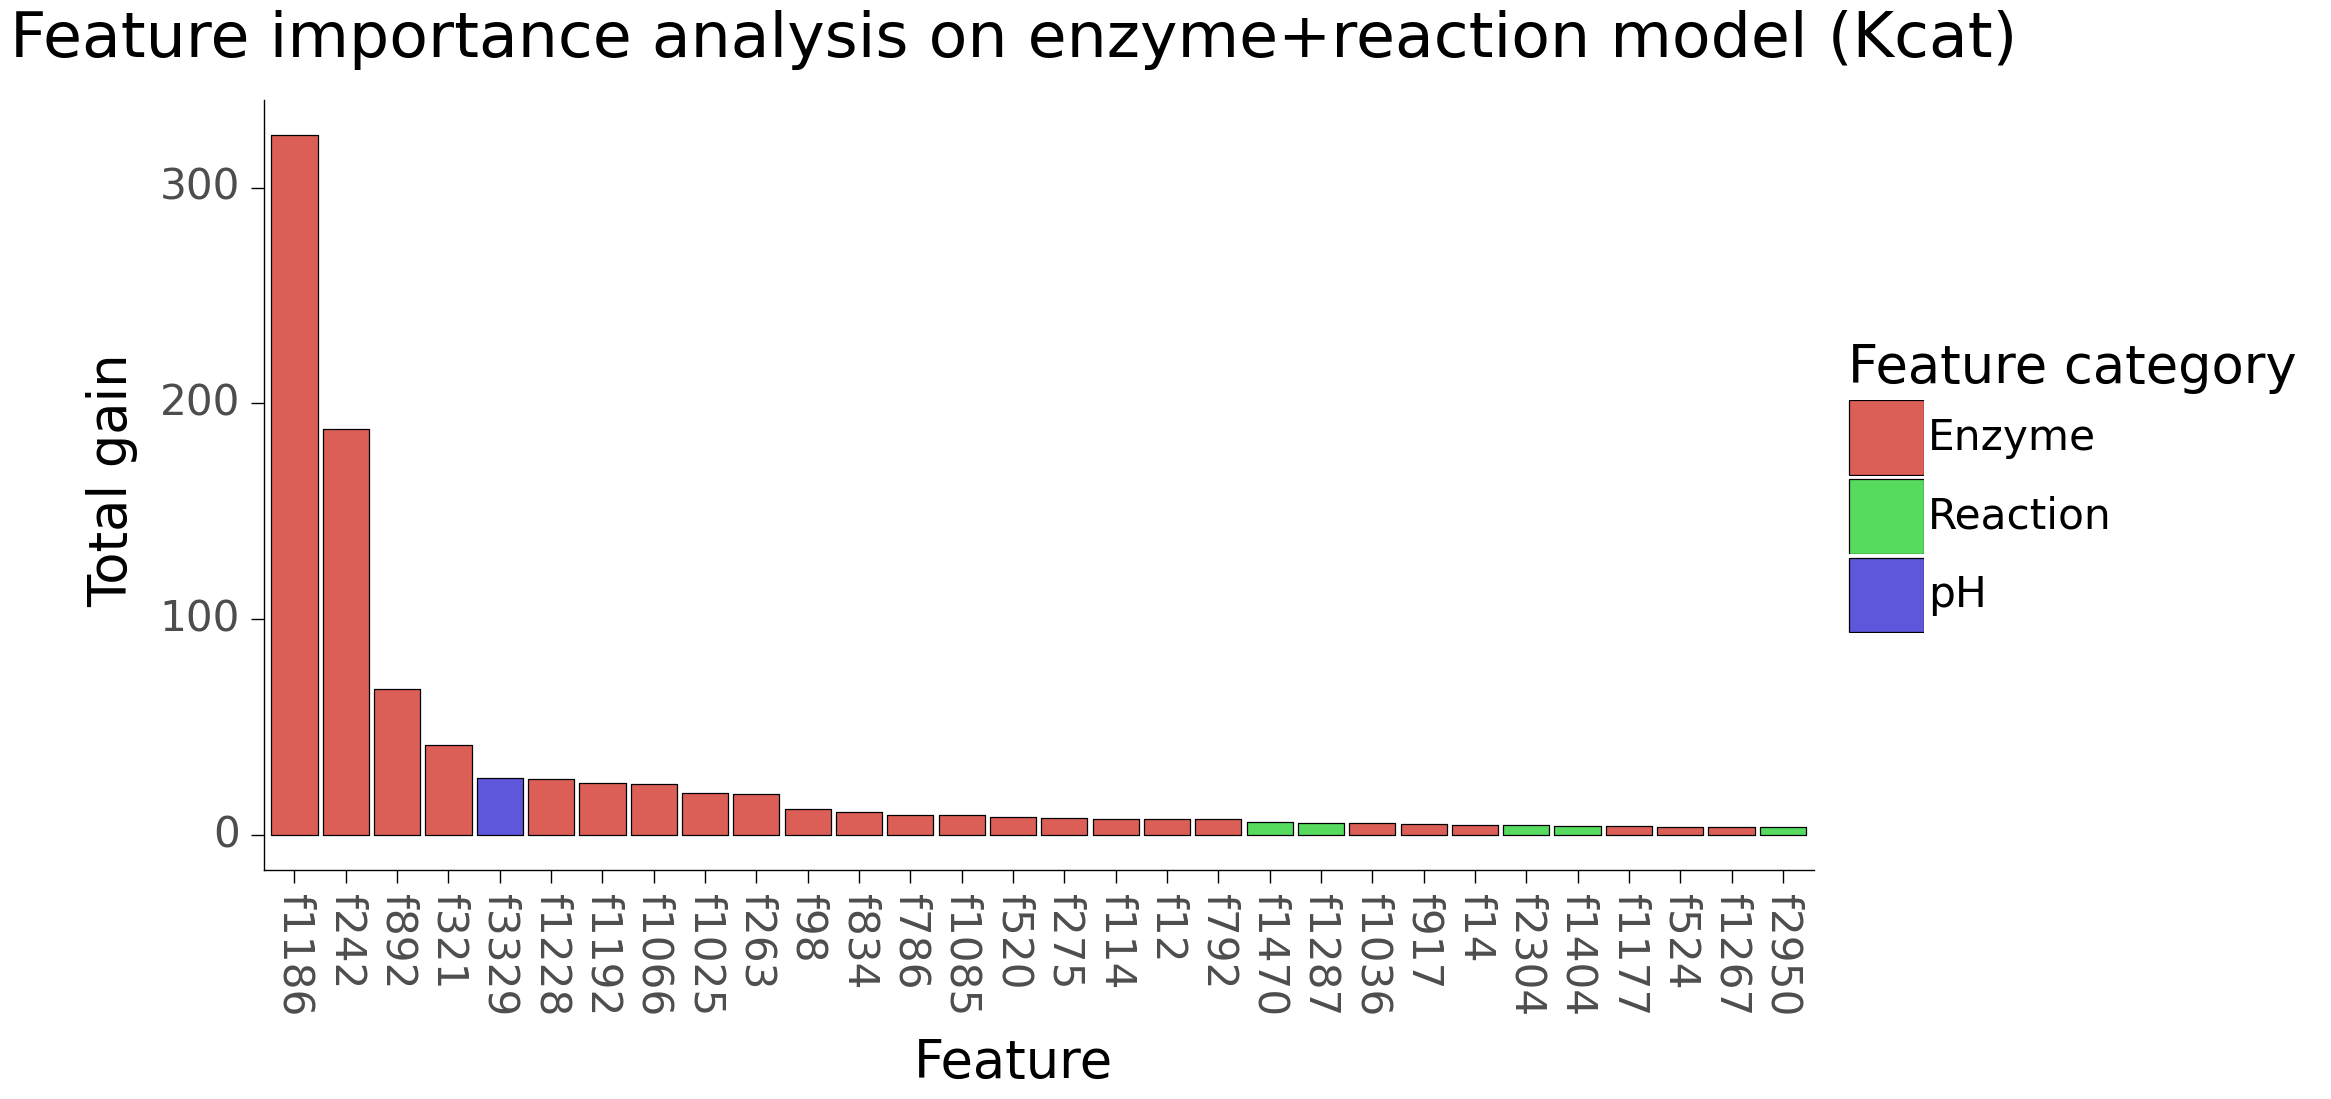

<ggplot: (-9223371901036447024)>

In [19]:
# plot
from plotnine import *
importances = bst.get_score(importance_type="total_gain")
listy = list(importances.items())
# Step 2: Sort the list of tuples based on values in descending order and keep the top 20
sorted_itESM = sorted(listy, key=lambda x: x[1], reverse=True)[:30]
print(sorted_itESM)
dicti = dict(sorted_itESM)
importances = pd.DataFrame({'Feature' : dicti.keys(), "Importance" : dicti.values()})
def condition(x):
    if int(x[1:]) <= 1279:
        return "Enzyme"
    elif 1279 <= int(x[1:]) <= 3327:
        return "Reaction"
    elif int(x[1:]) == 3328:
        return 'Temperature'
    else : 
        return 'pH'
importances["Feature category"] = importances["Feature"].apply(condition)
importances_order = importances.sort_values(by='Importance', ascending=False)["Feature"]
(ggplot(importances, aes(x="Feature", y="Importance", fill="Feature category"))
+ geom_bar(stat="identity", width=0.9, color='black')
+ scale_x_discrete(limits= importances_order)
+ labs(title="Feature importance analysis on enzyme+reaction model (Kcat)", y = "Total gain")
+ theme_classic(base_size=38)
+ theme(figure_size=(20, 10), axis_text_x=element_text(angle=-90), plot_title = element_text(ha = "center"))
)

In [25]:
bst.get_score(importance_type="weight")

{'f0': 4.0,
 'f1': 1.0,
 'f2': 2.0,
 'f4': 4.0,
 'f5': 3.0,
 'f9': 6.0,
 'f10': 1.0,
 'f11': 3.0,
 'f12': 1.0,
 'f14': 1.0,
 'f17': 1.0,
 'f20': 3.0,
 'f21': 1.0,
 'f22': 1.0,
 'f24': 1.0,
 'f25': 6.0,
 'f33': 1.0,
 'f35': 2.0,
 'f36': 2.0,
 'f38': 3.0,
 'f39': 2.0,
 'f42': 2.0,
 'f48': 11.0,
 'f54': 2.0,
 'f55': 2.0,
 'f58': 1.0,
 'f59': 1.0,
 'f60': 1.0,
 'f61': 1.0,
 'f64': 1.0,
 'f68': 1.0,
 'f71': 1.0,
 'f79': 2.0,
 'f84': 1.0,
 'f88': 1.0,
 'f91': 2.0,
 'f95': 4.0,
 'f98': 2.0,
 'f99': 3.0,
 'f102': 2.0,
 'f103': 6.0,
 'f106': 8.0,
 'f108': 2.0,
 'f109': 5.0,
 'f110': 2.0,
 'f114': 6.0,
 'f116': 2.0,
 'f117': 1.0,
 'f120': 3.0,
 'f125': 1.0,
 'f128': 1.0,
 'f138': 1.0,
 'f139': 2.0,
 'f142': 4.0,
 'f143': 1.0,
 'f145': 1.0,
 'f153': 3.0,
 'f157': 2.0,
 'f159': 1.0,
 'f163': 5.0,
 'f168': 3.0,
 'f172': 1.0,
 'f173': 1.0,
 'f178': 2.0,
 'f185': 2.0,
 'f188': 1.0,
 'f195': 2.0,
 'f196': 1.0,
 'f198': 5.0,
 'f199': 1.0,
 'f221': 3.0,
 'f226': 8.0,
 'f227': 2.0,
 'f237': 6.0,
 'f240':

##### Validating model

In [9]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [10]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_diff_fp.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2_diff_fp.npy"), val_Y)

(0.4996782360068266, 0.25352490481831885) 4.841545264265226 -0.26963349170898976 3.172614504869585 0.7581800470978288


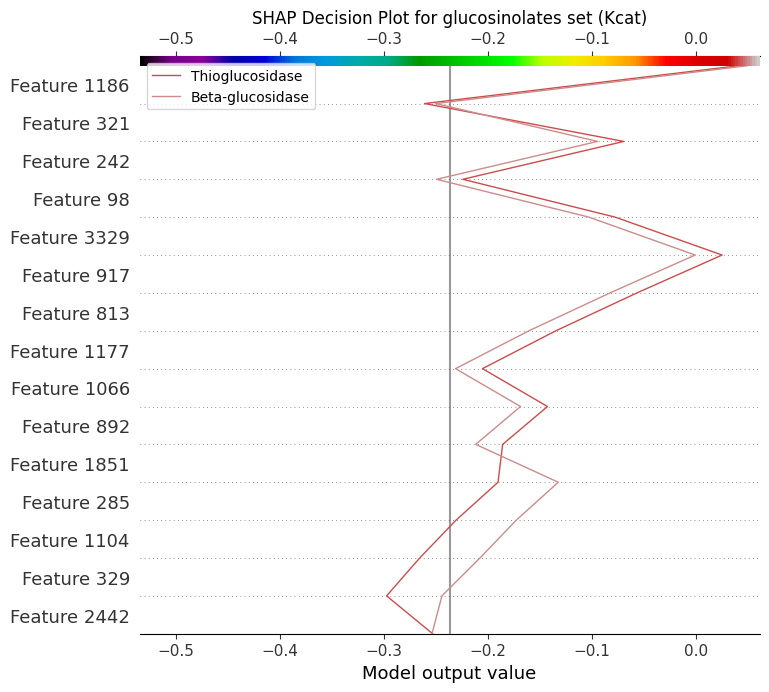

In [88]:
import shap
explainer = shap.TreeExplainer(bst)
explanation = explainer(val_X)

shap_values = explanation.values
shap_interaction_values = explainer.shap_interaction_values(val_X)
# make sure the SHAP values add up to marginal predictions
np.abs(shap_values.sum(axis=1) + explanation.base_values - y_val_pred).max()
# shap.plots.beeswarm(explanation)
fig, ax = plt.subplots(1, 1, figsize=(10, 15))
shap.decision_plot(explainer.expected_value, shap_values[2:4], legend_labels=["Thioglucosidase", "Beta-glucosidase"], plot_color="nipy_spectral", features=val_X[2:3],
                    feature_display_range=slice(-1, -16, -1), title = "SHAP Decision Plot for glucosinolates set (Kcat)", legend_location = "upper left")
plt.show()

# values = [shap_values, shap_values]

# shap.multioutput_decision_plot(
#     [explainer.expected_value, explainer.expected_value],
#     [shap_values, shap_values],
#     row_index = [2,3] 
    # feature_names=names
# )

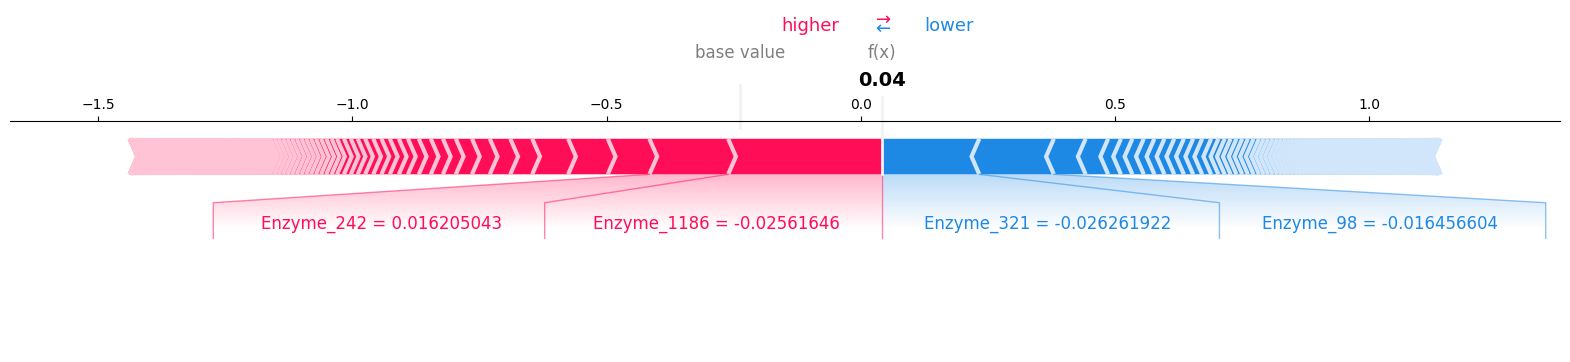

In [58]:
names = list()
for i in range(0, 1279):
    names.append("Enzyme_%s" %str(i))

for i in range(0, 2047):
    names.append("Reaction_%s" %str(i))

names.append(["Temperature", "pH"])

shap.force_plot(explainer.expected_value, shap_values[2], val_X[2], matplotlib=True, feature_names=names, text_rotation=0)

In [13]:
predictions = pd.DataFrame({"Actual kcat": [10**x for x in val_Y], "Predicted kcat" : [10**x for x in y_val_pred], "Difference" : abs(np.array([10**x for x in val_Y])-np.array([10**x for x in y_val_pred]))})

In [34]:
data_test[data_test["Main Substrate"] == "InChI=1S/C10H17NO9S2/c1-2-3-6(11-20-22(16,17)18)21-10-9(15)8(14)7(13)5(4-12)19-10/h2,5,7-10,12-15H,1,3-4H2,(H,16,17,18)/p-1/b11-6-/t5-,7-,8+,9-,10+/m1/s1"]

,ECs,Organism,Uniprot IDs,PMID,Type,kcat,Temperature,pH,Substrates,Products,...,structural_fp,MACCS FP,max_kcat_for_EC,frac_of_max_UID,frac_of_max_RID,frac_of_max_EC,GNN FP,Sequence ID_y,ESM2,log10_kcat


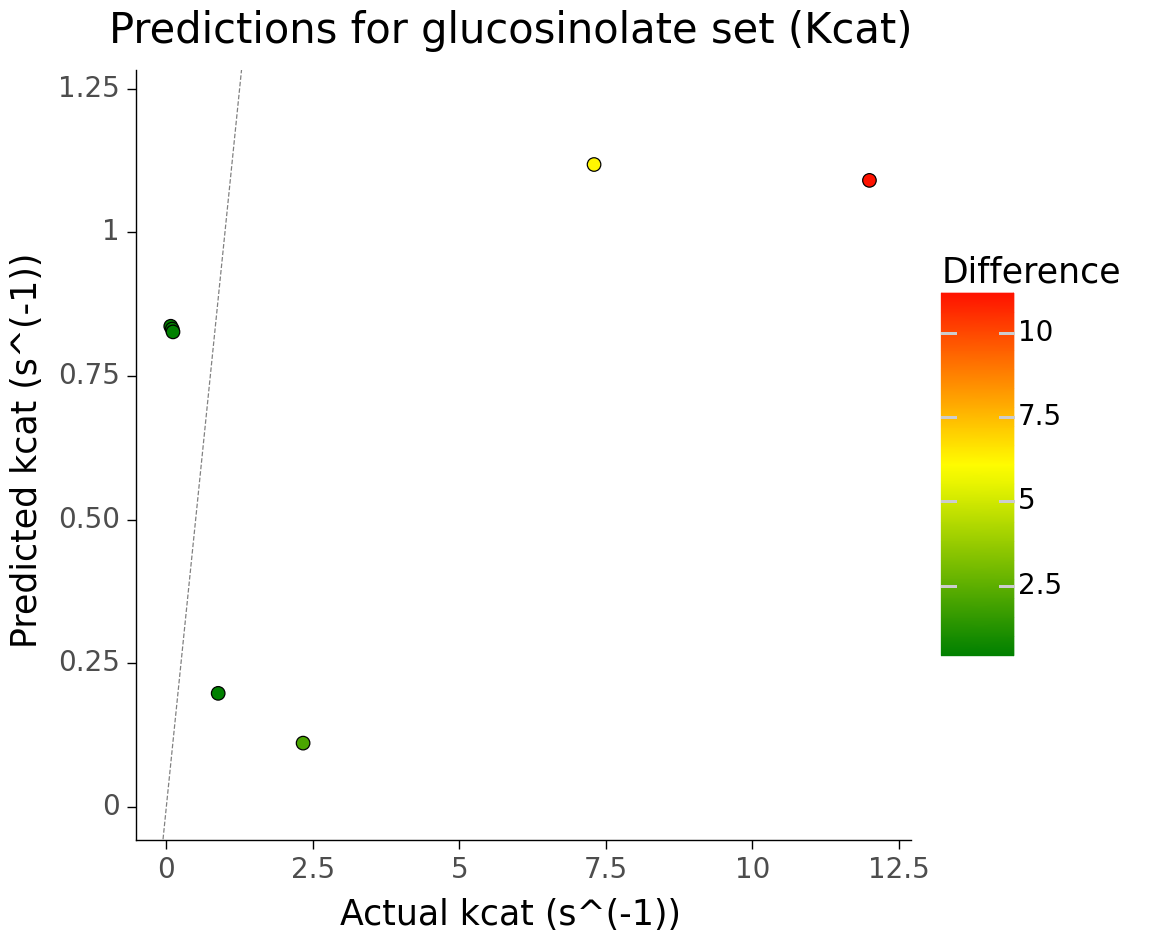

<ggplot: (-9223371855095468956)>

In [120]:
from plotnine import *

import textwrap

(
    ggplot(predictions, aes(x = "Actual kcat", y="Predicted kcat", fill="Difference"))
    + geom_point(color="black", size=5, position = position_jitter(width = 0.0015)) 
    + geom_abline(slope = 1, intercept = 0, color = "grey", linetype="dashed")
    + scale_fill_gradient2(low = "green", mid="yellow", high = "red", midpoint=6)
    # + scale_x_discrete(labels= [textwrap.fill(label, width=10) for label in ["Enzyme","Enzyme+reaction", "Enzyme+substrate", "Enzyme+substrate+reaction", "Reaction", "Substrate", "Substrate+reaction"]])
    + labs(title="Predictions for glucosinolate set (Kcat)", x="Actual kcat (s^(-1))", y="Predicted kcat (s^(-1))", fill="Difference")
    + theme_classic(base_size=25)
    + xlim(min(predictions["Actual kcat"]), max(predictions["Actual kcat"]+0.1))
    + ylim(min(predictions["Predicted kcat"]-0.1), max(predictions["Predicted kcat"]+0.1))
    + theme(figure_size=(10, 10))
)


## 3. Training a model with enzyme, substrate (MACCS fp) and reaction information (ESM-2/diff_fp) + Temperature + pH:

#### (a) Creating input matrices:

In [121]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [122]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [123]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 750.0, 'reg_alpha': 0.8, 'reg_lambda': 0.6}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 7.0, 'min_child_weight': 1.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.4}

#### (c) Training and validating model:

In [124]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [125]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2_gnn_fp_diff_fp.npy"), np.array(R2))

[0.595093495471497, 0.3770873269118614, -0.10271879619312088, -0.04317444809836638, -0.10105529637402483]
[2.8048848391263315, 13.288576887005195, 131.8840992336321, 28.93302412052766, 42.043729361887515]
[0.3353917898708817, -0.9111698845579033, -0.056930712699331476, -0.11560169429029488, -0.0808688106972586]
[2.0277971306503586, 9.690249879115727, 32.12050358182761, 12.31564398355763, 12.284343942145721]
[1.6677132877337515, 9.733084814264004, 1.1252410483486783, 3.358644398064844, 1.1175453503439572]


In [126]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)
MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))

np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), test_Y)

0.968 28.8290104576 0.698 6.3474243759 0.0420167093


In [127]:
y_test_pred_esm1b_ts_drfp = y_test_pred

#### (d) Training model with test and train data for production mode:

In [128]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["difference_fp"])), np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["difference_fp"])), np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [129]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, "xgboost_train_and_test.pkl"), "wb"))

(0.9998894632120197, 9.767225602656046e-64) 6.943068176289562 0.9825029944101197


In [130]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["difference_fp"])), np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

In [131]:
dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2_gnn_fp_diff_fp.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2_gnn_fp_diff_fp.npy"), val_Y)

(-0.38225083347318695, 0.397422217662461) 4.8341194352659995 -0.2657418205911737 3.605257043250575 2.1127105985584644


In [132]:
plt.scatter(val_Y, np.zeros_like(val_Y), c='blue', edgecolors='black',s=15)
plt.scatter(np.mean(val_Y), 0, c='red', edgecolors='black',s=20)

In [133]:
importances = bst.get_score()

In [134]:
print(len(data_train["ESM2"][1]))
print(len(data_train["difference_fp"][1]))
print(len(data_train["MACCS FP"][1]))

1280
2048
167


In [135]:
importances

{'f0': 13.0,
 'f1': 3.0,
 'f2': 1.0,
 'f3': 4.0,
 'f4': 1.0,
 'f5': 4.0,
 'f8': 1.0,
 'f18': 1.0,
 'f20': 4.0,
 'f21': 1.0,
 'f26': 2.0,
 'f33': 1.0,
 'f35': 2.0,
 'f38': 2.0,
 'f39': 1.0,
 'f40': 1.0,
 'f41': 2.0,
 'f46': 1.0,
 'f47': 1.0,
 'f51': 1.0,
 'f60': 1.0,
 'f66': 3.0,
 'f98': 1.0,
 'f106': 1.0,
 'f130': 1.0,
 'f135': 1.0,
 'f141': 1.0,
 'f160': 1.0,
 'f169': 2.0,
 'f191': 1.0,
 'f199': 1.0,
 'f202': 1.0,
 'f217': 1.0,
 'f220': 1.0,
 'f224': 5.0,
 'f227': 2.0,
 'f242': 3.0,
 'f243': 1.0,
 'f247': 1.0,
 'f251': 1.0,
 'f256': 5.0,
 'f258': 2.0,
 'f260': 2.0,
 'f261': 1.0,
 'f262': 1.0,
 'f264': 1.0,
 'f265': 3.0,
 'f268': 1.0,
 'f273': 1.0,
 'f275': 1.0,
 'f283': 1.0,
 'f287': 1.0,
 'f290': 1.0,
 'f291': 1.0,
 'f292': 1.0,
 'f304': 1.0,
 'f309': 1.0,
 'f310': 1.0,
 'f314': 1.0,
 'f322': 2.0,
 'f323': 1.0,
 'f329': 1.0,
 'f330': 1.0,
 'f340': 1.0,
 'f350': 1.0,
 'f352': 2.0,
 'f363': 1.0,
 'f368': 1.0,
 'f375': 1.0,
 'f376': 1.0,
 'f378': 2.0,
 'f387': 1.0,
 'f391': 1.0,
 'f395'

In [136]:
# data_combined = pd.concat([data_train, data_test],ignore_index=True)


In [137]:
# plt.hist([10**x for x in data_combined["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [138]:
# plt.hist([10**x for x in data_val["log10_kcat"]], bins=50, color='skyblue', edgecolor='black')

In [139]:
# def calculate_identity_ignore_gaps(seq1, seq2):
#     identical_residues = sum([1 for x, y in zip(seq1, seq2) if x == y and x != "-"])
#     pid = identical_residues / sum([1 for x in seq1 if x != "-"]) 
#     return pid

# from Bio import Align
# from Bio.Align import substitution_matrices

# data_val["max_identity"] = np.nan

# aligner=Align.PairwiseAligner()
# aligner.substitution_matrix = substitution_matrices.load("BLOSUM62")
# aligner.mode = "global"
# aligner.extend_gap_score = -0.5
# aligner.open_gap_score = -10

# for i in data_val.index:
#     identities = []
#     for j in data_combined.index:
#         seq1 = str(data_val["Sequence"][i])
#         seq2 = str(data_combined["Sequence"][j])
#         if 'U' in seq1:
#             seq1 = seq1.replace('U', 'C')
#         if 'U' in seq2:
#             seq2 = seq2.replace('U', 'C')
#         alignments = aligner.align(seq1, seq2)
#         identities.append(calculate_identity_ignore_gaps(alignments[0][0], alignments[0][1]))
#     data_val["max_identity"][i] = max(identities)

In [140]:
# data_val["max_identity"] = data_val["max_identity"]*100

In [141]:
# import matplotlib.pyplot as plt
# import sklearn.metrics as sk
# import math

# fig, ax = plt.subplots(figsize= (10,8))
# plt.rcParams.update({'font.size': 28})

# splits = ["0-40%", "40-80%", "80-99%"]
# lower_bounds = [0,40,80]
# upper_bounds = [40,80,99]

# points1 = []
# points2 = []
# n_points1, n_points2 = [], []

# for i, split in enumerate(splits):

#     lb, ub = lower_bounds[i], upper_bounds[i]
    
#     help_df = data_val.loc[data_val["max_identity"]>= lb].loc[data_val["max_identity"]<= ub]
#     y_true = np.array([10**x for x in help_df["log10_kcat"]])
#     y_pred = np.array([10**x for x in help_df["Estimate kcat"]])
#     n_kcat = len(y_pred)
#     R2 =  sk.r2_score(y_true, y_pred)
#     abs_error = abs(y_true - y_pred)
#     rmse = math.sqrt(np.mean(abs(y_true - y_pred)**2))
#     print(len(y_true))
#     print(split, R2, rmse)
#     points1.append(R2)
#     points2.append(rmse)
#     n_points1.append(n_kcat)


# ticks2 = np.array(range(len(splits)))
# labs = splits
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((-0.1,2.5))
# # plt.xlim((-0.2, 3.2))
# plt.legend(loc = "lower right", fontsize=20)
# plt.ylabel('RMSE')
# plt.xlabel('Enzyme sequence identity')
# # ax.yaxis.set_label_coords(-0.15, 0.5)
# # ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([-0.15,4], [0,0], color='grey', linestyle='dashed')


# plt.plot([0,1,2], points2, c= "black", linewidth=2)

# for i, split in enumerate(splits):
#     points1.append(R2)
    
#     if i ==0:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")

#     else:
#         plt.scatter(i, points2[i], c='black', marker="o", linewidths= 8)
#         ax.annotate(n_points1[i], (i-0.08, points2[i]+0.08), fontsize=17, c= "red", weight = "bold")
            
     
# plt.savefig(join("..","..", "data", "sequence_identity.png"))
# plt.show()

In [142]:
# EC_kcat_pred =[[] for _ in range(6)]
# EC_kcat =[[] for _ in range(6)]
# for ind in data_val.index:
#     try:
#         EC = int(data_val["ECs"][ind][0][0])
#         EC_kcat[EC-1].append(data_val["log10_kcat"][ind])
#         EC_kcat_pred[EC-1].append(data_val["Estimate kcat"][ind])
#     except IndexError:
#         pass

In [143]:
# fig, ax = plt.subplots(figsize= (8,8))
# plt.rcParams.update({'font.size': 28})

# classes = [str(i) for i in range(1,7)]

# for i in range(len(EC_kcat)):
    
#     circle = plt.Circle((np.mean(EC_kcat[i]), np.mean(EC_kcat_pred[i]) ),
#                         np.sqrt(len(EC_kcat_pred[i]))/300, color='navy', fill = True)
#     ax.add_artist(circle)
#     if i ==5:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.01, np.mean(EC_kcat_pred[i])-0.05), fontsize=17, c='red', weight = "bold")
#     else:
#         ax.annotate("EC"+ str(i+1), (np.mean(EC_kcat[i])+0.03, np.mean(EC_kcat_pred[i])-0.01), fontsize=17, c='red', weight = "bold")
    

# ticks2 = [0.2, 0.6,1,1.4,1.8]
# labs = ticks2
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='x', length=0, rotation = 0)

# ax.set_yticks(ticks2)
# ax.set_yticklabels(labs,  y= -0.03, fontsize=26)
# ax.tick_params(axis='y', length=0, rotation = 0)

# plt.ylim((0,2))
# plt.xlim((0, 2))
# plt.legend(loc = "upper left", fontsize=20)
# plt.xlabel('mean measured \n $k_{cat}$ value on $\log_{10}$-scale')
# plt.ylabel('mean predicted \n $k_{cat}$ value on $\log_{10}$-scale')
# ax.yaxis.set_label_coords(-0.15, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.13)

# plt.plot([0,2], [0,2], color='grey', alpha = 0.3, linestyle='dashed')
# plt.savefig(join("..", "..", "data", split, "EC_classes_mean_kcat.png"))
# plt.show()

In [144]:
# import scipy

# train_fps = [data_combined["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_combined.index]
# test_fps = [data_val["difference_fp"][ind][:3276].reshape(1,-1).astype(int) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["reaction_sim"] = max_sim

# data_val["reaction_sim"]= (data_val["reaction_sim"] - np.min(data_val["reaction_sim"]))
# data_val["reaction_sim"] = data_val["reaction_sim"]\np.max(data_val["reaction_sim"])

In [145]:
# train_fps = [np.array(list(data_combined["MACCS FP"][ind])).reshape(1,-1) for ind in data_combined.index]
# test_fps = [np.array(list(data_val["MACCS FP"][ind])).reshape(1,-1) for ind in data_val.index]

# max_sim = []

# for fp in test_fps:
#     jaccard_sim = np.array([1 - scipy.spatial.distance.cdist(fp,train_fp, metric='jaccard')[0][0] for train_fp in train_fps])
#     max_sim.append(np.max(jaccard_sim))
    
# data_val["substrate_sim"] = max_sim

# data_val["substrate_sim"]= (data_val["substrate_sim"] - np.min(data_val["substrate_sim"]))
# data_val["substrate_sim"] = data_val["substrate_sim"]\np.max(data_val["substrate_sim"])

In [146]:
# data_val["global_sim"] = (data_val["max_identity"]/100)*data_val["reaction_sim"]*data_val["substrate_sim"]

In [147]:
# data_val.describe()

In [148]:
# import matplotlib.pyplot as plt
# import math
# import scipy as sci
# help_df = data_val

# sim_bins_lb = [0.0, 0.4, 0.8]
# sim_bins_ub = [0.4, 0.8, 1]
# r2_scores, n_points, pearson_r, rmse = [], [], [], []
# for i in range(len(sim_bins_lb)):
#     help_df2 = help_df.loc[help_df["global_sim"] <= sim_bins_ub[i]].loc[help_df["global_sim"] >= sim_bins_lb[i]]
#     pred = np.array([10**x for x in help_df2["log10_kcat"]])
#     true = np.array([10**x for x in help_df2["Estimate kcat"]])
#     r2_scores.append(sk.r2_score(true, pred))
#     pearson_r.append(sci.stats.pearsonr(true, pred)[0])
#     rmse.append(math.sqrt(np.mean(abs(true - pred)**2)))
#     n_points.append(len(pred))
#     print("%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]), r2_scores[-1], pearson_r[-1], rmse[-1], len(pred))
    

# plt.rcParams.update({'font.size': 24})

# fig, ax = plt.subplots(figsize= (8,6))

# for i in range(len(sim_bins_lb)):    
#     plt.scatter(i, rmse[i], c='navy', marker="o", linewidths= 8)
#     ax.annotate(n_points[i], (i-0.08, rmse[i]+0.05), fontsize=17, c= "black", weight = "bold")

    
# plt.xlabel('Reaction similarity score')
# plt.ylabel('RMSE')
# ax.yaxis.set_label_coords(-0.2, 0.5)
# ax.xaxis.set_label_coords(0.5,-0.23)

# ticks2 = np.array(range(len(sim_bins_lb)))
# labs = ["%s - %s" % (sim_bins_lb[i], sim_bins_ub[i]) for i in range(len(sim_bins_lb))]
# ax.set_xticks(ticks2)
# ax.set_xticklabels(labs,  y= -0.03, fontsize=20)
# ax.tick_params(axis='x', length=0, rotation = 0)

# # plt.ylim((0.5,2))
# #plt.xlim((-0.5, 3.2))

# # plt.plot([-0.49, 4], [0,0], color='grey', linestyle='dashed')
# #plt.savefig(join("..","..", "data", "figures", "Reaction_Similarity_Score.eps"))
# plt.show()

## 4. Training a model with enzyme information (ESM-2) + Temperature + pH:

#### (a) Creating input matrices:

In [149]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [150]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [151]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 250.0, 'reg_alpha': 0.4, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 1000, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
else:
    param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 1.0, 'max_depth': 8.0, 'min_child_weight': 4.0, 'num_rounds': 250, 'reg_alpha': 0.6, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [152]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [153]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_ESM2.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_ESM2.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_ESM2.npy"), np.array(R2))

[0.25632931264171993, 0.5752235139025781, -0.10104256914693022, -0.24135731243204087, 0.07395880419386214]
[4.639047320246003, 13.463468270427134, 131.93125992705737, 29.483199885506124, 41.15118957888805]
[-0.8179973129291203, -0.9618068589432924, -0.05768674769965809, -0.15843251970004246, -0.035464727864746415]
[3.463862023807774, 9.879165095594105, 31.791465657874777, 11.378863572109994, 11.595003771809337]
[2.3048229867281713, 9.66825853592817, 1.094072389762641, 0.9711974520088072, 1.3442002034309788]


In [154]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2.npy"), test_Y)

0.671 44.4052472984 0.284 9.8043043898 0.0658261447


In [155]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [156]:
train_X = np.array(list(data_train["ESM2"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["ESM2"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [157]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, 
                          "xgboost_train_and_test.pkl"), "wb"))

(0.7038506569236906, 1.6748901654414704e-06) 45.351363023509684 0.2534798073744966


#### (e) Validating model:

In [158]:
val_X = np.array(list(data_val["ESM2"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_test_pred_xgboost_ESM2.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_ESM2.npy"), val_Y)

(0.16906063371006824, 0.7170776439357619) 4.420656334986048 -0.05848299407667046 3.5331396405730584 2.6944986937222843


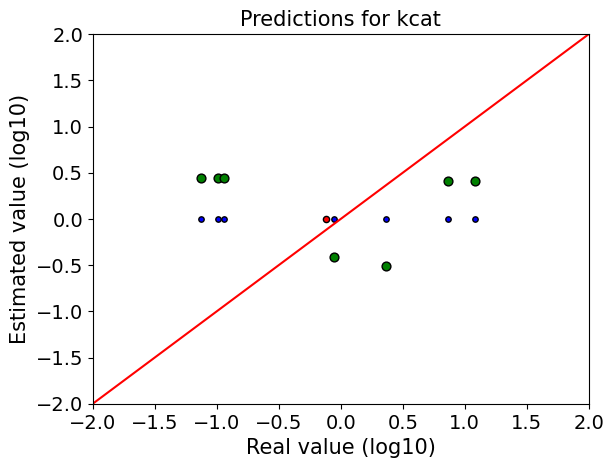

In [159]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

plt.scatter(val_Y,y_val_pred,c='green', edgecolors='black',s=40)
    
plt.xlim(-2,2)
plt.ylim(-2,2)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Real value (log10)', fontsize=15)
plt.ylabel('Estimated value (log10)', fontsize=15)
plt.title('Predictions for kcat', fontsize=15)
plt.axline((1, 1), slope=1, c='red')
plt.show()

## 5. Training a model with main substrate information (MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [160]:
train_X = np.array(list(data_train['GNN FP']))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test['GNN FP']))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [161]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [162]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.2, 'reg_lambda': 0.4}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 3.0, 'min_child_weight': 6.0, 'num_rounds': 500.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 6.0, 'num_rounds': 100, 'reg_alpha': 1.0, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [163]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [164]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp.npy"), np.array(R2))

[0.554665994520811, -0.09038034172229358, -0.10795248204878884, 0.17687976200165784, -0.24314146126766611]
[2.9462872392736816, 12.735326296267937, 131.72631053540022, 28.581342787540677, 41.777277394320585]
[0.26669304931965465, -0.7553450526266343, -0.054403160738432765, -0.08864620822580438, -0.06721221898086505]
[2.4737441580687287, 9.356426940565667, 31.558347026733014, 11.275320271012362, 10.90576367436407]
[2.2146531340921154, 7.081337910598631, 1.1869328467349356, 1.8600774551724006, 1.2573965729636318]


In [165]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_gnn_fp.npy"), test_Y)

0.406 52.6720270958 -0.007 9.7708469437 0.2286344017


In [166]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [167]:
train_X = np.array(list(data_train["GNN FP"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["GNN FP"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [168]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, 
                          "xgboost_train_and_test.pkl"), "wb"))

(0.6064171719499298, 8.843821002816001e-05) 52.67432600663176 -0.0070681144737627655


#### (e) Validating model:

In [169]:
val_X = np.array(list(data_val["GNN FP"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_gnn_fp.npy"), val_Y)

(0.07535137464964581, 0.8724423792048596) 4.704298103881856 -0.19867113194802277 2.882039580902627 1.2979828230106703


## 6. Training a model with reaction information (diff-fp) + Temperature + pH:

#### (a) Creating input matrices:

In [211]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [212]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [213]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 4.0, 'max_depth': 7.0, 'min_child_weight': 2.0, 'num_rounds': 100, 'reg_alpha': 0.0, 'reg_lambda': 0.2}
elif split == "Arabidopsis":
    param = {"random_state": 42,'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.1, 'max_delta_step': 2.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 750.0, 'reg_alpha': 1.0, 'reg_lambda': 1.0}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 4.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 0.8, 'reg_lambda': 0.2}

#### (c) Training and validating model:

In [214]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [215]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_diff_fp.npy"), np.array(R2))

[0.49763489159726204, -0.3556020257341571, 0.16958955619376923, 0.3892767491276023, 0.10483802962824375]
[3.0184102708449068, 13.349407882549826, 131.09300862076017, 28.313779653400164, 41.0488763919229]
[0.23035195262442576, -0.9287074230240027, -0.044289002826322976, -0.06835897519223422, -0.030322227865680285]
[2.4375754492130657, 10.080968515314424, 31.099510743140097, 10.913281454712125, 10.64566545974126]
[2.2970139925534507, 8.07913108483774, 1.1841030955909047, 1.9265619252132717, 2.2488774455229104]


In [216]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_diff_fp.npy"), test_Y)

0.475 51.5672627761 0.035 9.5787735821 0.0714583765


In [217]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [218]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [219]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, 
                          "xgboost_train_and_test.pkl"), "wb"))

(0.7159242942451538, 9.16545178965692e-07) 49.61584231605007 0.10648549232822857


#### (e) Validating model:

In [220]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X, np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
data_val["Estimate kcat"] = y_val_pred

MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_test_pred_xgboost_diff_fp.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_diff_fp.npy"), val_Y)

(-0.73367495784963, 0.06053861608609125) 4.954802254483241 -0.3297286628590108 3.4839095490001872 1.803068327890961


## 7. Training a model with reaction and main substrate information (diff-fp/MACCS) + Temperature + pH:

#### (a) Creating input matrices:

In [221]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X, np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = train_X.astype(float)
test_X = test_X.astype(float)

#### (b) Hyperparameter optimization:

In [222]:
# def cross_validation_mse_gradient_boosting(param):
#     num_round = param["num_rounds"]
#     del param["num_rounds"]
#     param["max_depth"] = int(np.round(param["max_depth"]))
#     # param["device"] = "cuda"
#     param["tree_method"] = "gpu_hist"
#     param["sampling_method"] = "gradient_based"
    
#     MSE = []
#     R2 = []
#     for i in range(5):
#         train_index, test_index  = train_indices[i], test_indices[i]
#         dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
#         dvalid = xgb.DMatrix(train_X[test_index])
#         bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
#         y_valid_pred = bst.predict(dvalid)
#         MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
#         R2.append(r2_score(np.reshape(train_Y[test_index], (-1)),  y_valid_pred))
#     return(-np.mean(R2))

# space_gradient_boosting = {
#     "learning_rate": hp.choice("learning_rate", [0.01,0.1,0.2]),
#     "max_depth": hp.quniform("max_depth", 3, 10, 1),
#     # "subsample": hp.quniform("subsample", 0.5, 1, 0.5),
#     "reg_lambda": hp.quniform("reg_lambda", 0, 1, 0.2),
#     "reg_alpha": hp.quniform("reg_alpha", 0, 1, 0.2),
#     "max_delta_step": hp.quniform("max_delta_step", 1, 5, 1),
#     "min_child_weight": hp.quniform("min_child_weight", 1, 6, 1),
#     "num_rounds":  hp.choice("num_rounds", [100,250,500,1000])
#     }

# rstate = np.random.default_rng(42)
# trials = Trials()
# best = fmin(fn = cross_validation_mse_gradient_boosting, space = space_gradient_boosting,
#             algo=rand.suggest, max_evals = 20, trials=trials, return_argmin=False, rstate=rstate)

# print(best)
# param = best
# param["random_state"] = 42

In [223]:
if split == "full":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 2.0, 'max_depth': 8.0, 'min_child_weight': 5.0, 'num_rounds': 500, 'reg_alpha': 0.4, 'reg_lambda': 0.0}
elif split == "Arabidopsis":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
# elif split == "Brassicaceae":
#     param = {"random_state": 42, 'learning_rate': 0.2, 'max_delta_step': 3.0, 'max_depth': 4.0, 'min_child_weight': 4.0, 'num_rounds': 250.0, 'reg_alpha': 0.8, 'reg_lambda': 0.4}
elif split == "wildtype":
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 5.0, 'max_depth': 5.0, 'min_child_weight': 3.0, 'num_rounds': 1000, 'reg_alpha': 0.6, 'reg_lambda': 0.8}
else:
    param = {"random_state": 42, 'learning_rate': 0.01, 'max_delta_step': 1.0, 'max_depth': 9.0, 'min_child_weight': 3.0, 'num_rounds': 250, 'reg_alpha': 1.0, 'reg_lambda': 0.8}

#### (c) Training and validating model:

In [224]:
num_round = param["num_rounds"]
param["max_depth"] = int(np.round(param["max_depth"]))
param["tree_method"] = "gpu_hist"
param["sampling_method"] = "gradient_based"
del param["num_rounds"]

In [225]:
R2 = []
MSE = []
Pearson = []
MAE = []
MedAE = []

for i in range(5):
    train_index, test_index  = train_indices[i], test_indices[i]
    dtrain = xgb.DMatrix(train_X[train_index], label = train_Y[train_index])
    dvalid = xgb.DMatrix(train_X[test_index])
    
    bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)
    
    y_valid_pred = bst.predict(dvalid)
    MSE.append(np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(train_Y[test_index], (-1))]) - np.array([10**x for x in y_valid_pred]))**2)))
    R2.append(r2_score([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred]))
    Pearson.append(stats.pearsonr([10**x for x in np.reshape(train_Y[test_index], (-1))], [10**x for x in y_valid_pred])[0])
    MAE.append(np.mean(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))
    MedAE.append(np.median(abs(np.array([10**x for x in train_Y[test_index]]) - np.array([10**x for x in y_valid_pred]))))

    # MSE.append(np.mean(abs(np.reshape(train_Y[test_index], (-1)) - y_valid_pred)**2))
    # R2.append(r2_score(np.reshape(train_Y[test_index], (-1)), y_valid_pred))
    # Pearson.append(stats.pearsonr(np.reshape(train_Y[test_index], (-1)), y_valid_pred)[0])

print(Pearson)
print(MSE)
print(R2)
print(MAE)
print(MedAE)

np.save(join("..", "..", "data", split, "Pearson_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(Pearson))
np.save(join("..", "..", "data", split, "MSE_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(MSE))
np.save(join("..", "..", "data", split, "R2_CV_xgboost_gnn_fp_diff_fp.npy"), np.array(R2))

[0.5402129485831194, -0.25653112106518294, -0.0383363081993121, 0.34181082025135645, 0.011730303618118675]
[2.934253288492038, 13.46104524185091, 131.61431847277208, 28.13102507182478, 41.21215670509687]
[0.27267112089103385, -0.9611007873370212, -0.05261104210656664, -0.05461179088598778, -0.03853516513217525]
[2.352787231102244, 10.152396443257528, 31.404535778782662, 11.326958042642426, 11.900701775184594]
[2.430302131972455, 9.151666383056416, 1.2840096921690565, 2.186279439543082, 2.2020670963211226]


In [226]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X, label = test_Y)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

data_test["Estimate kcat"] = y_test_pred

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in test_Y]), np.array([10**x for x in y_test_pred]))
MAE = np.mean(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))
MedAE = np.median(abs(np.array([10**x for x in test_Y]) - np.array([10**x for x in y_test_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)
# MAE = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred))

print(np.round(Pearson[0],3) , np.round(MSE_dif_fp_test, 10), np.round(R2_dif_fp_test,3), np.round(MAE, 10), np.round(MedAE, 10))


np.save(join("..", "..", "data", split, "y_test_pred_xgboost_gnn_fp_diff_fp.npy"), bst.predict(dtest))
np.save(join("..", "..", "data", split, "y_test_true_xgboost_gnn_fp_diff_fp.npy"), test_Y)

0.994 43.1384809688 0.325 7.9157672033 0.0551798372


In [227]:
y_test_pred_esm1b_ts_drfp = y_test_pred
# data_test["Estimate kcat"] = [10**x for x in data_test["Estimate kcat"]]
# filtered_df = data_test[data_test['Uniprot IDs'].apply(lambda x: "Q9LE06" in x)]
# filtered_df

#### (d) Training model with test and train data for production mode:

In [228]:
train_X = np.array(list(data_train["difference_fp"]))
train_X = np.concatenate([train_X, np.array(list(data_train["GNN FP"])), np.array(list(data_train["Temperature"]))[:, np.newaxis], np.array(list(data_train["pH"]))[:, np.newaxis]], axis = 1)
train_Y = np.array(list(data_train["log10_kcat"]))

test_X = np.array(list(data_test["difference_fp"]))
test_X = np.concatenate([test_X,  np.array(list(data_test["GNN FP"])), np.array(list(data_test["Temperature"]))[:, np.newaxis], np.array(list(data_test["pH"]))[:, np.newaxis]], axis = 1)
test_Y = np.array(list(data_test["log10_kcat"]))

train_X = np.concatenate([train_X, test_X])
train_Y = np.concatenate([train_Y, test_Y])

train_X = train_X.astype(float)
test_X = test_X.astype(float)

In [229]:
dtrain = xgb.DMatrix(train_X, label = train_Y)
dtest = xgb.DMatrix(test_X)

bst = xgb.train(param, dtrain, int(num_round), verbose_eval=False)

y_test_pred = bst.predict(dtest)

MSE_dif_fp_test = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(test_Y, (-1))]) - np.array([10**x for x in y_test_pred]))**2))
R2_dif_fp_test = r2_score(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(test_Y, (-1))]), np.array([10**x for x in y_test_pred]))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_test, R2_dif_fp_test)

pickle.dump(bst, open(join("..", "..", "data", split, 
                          "xgboost_train_and_test.pkl"), "wb"))

(0.9981967821776613, 3.957469071916524e-43) 38.76043773058581 0.4546965855715954


#### (e) Validating model:

In [232]:
val_X = np.array(list(data_val["difference_fp"]))
val_X = np.concatenate([val_X,  np.array(list(data_val["GNN FP"])), np.array(list(data_val["Temperature"]))[:, np.newaxis], np.array(list(data_val["pH"]))[:, np.newaxis]], axis = 1)
val_Y = np.array(list(data_val["log10_kcat"]))

val_X = val_X.astype(float)

dval = xgb.DMatrix(val_X)

y_val_pred = bst.predict(dval)
# data_val["Estimate kcat"] = y_val_pred
import sklearn as sk
MSE_dif_fp_val = np.sqrt(np.mean(abs(np.array([10**x for x in np.reshape(val_Y, (-1))]) - np.array([10**x for x in y_val_pred]))**2))
R2_dif_fp_val = r2_score(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
Pearson = stats.pearsonr(np.array([10**x for x in np.reshape(val_Y, (-1))]), np.array([10**x for x in y_val_pred]))
MAE = np.mean(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))
MedAE = np.median(abs(np.array([10**x for x in val_Y]) - np.array([10**x for x in y_val_pred])))

# MSE_dif_fp_test = np.mean(abs(np.reshape(test_Y, (-1)) - y_test_pred)**2)
# R2_dif_fp_test = r2_score(np.reshape(test_Y, (-1)), y_test_pred)
# Pearson = stats.pearsonr(np.reshape(test_Y, (-1)), y_test_pred)

print(Pearson, MSE_dif_fp_val, R2_dif_fp_val, MAE, MedAE)
np.save(join("..", "..", "data", split, "y_test_pred_xgboost_diff_fp_gnn_fp.npy"), y_val_pred)
np.save(join("..", "..", "data", split, "y_test_true_xgboost_diff_fp_gnn_fp.npy"), val_Y)

(0.24248719407410266, 0.6003362309408865) 4.4278074922820005 -0.061910313544573325 2.9350235625592007 1.5619890767609368


In [ ]:
results_test = pd.read_csv('../../data/Results_test.csv')

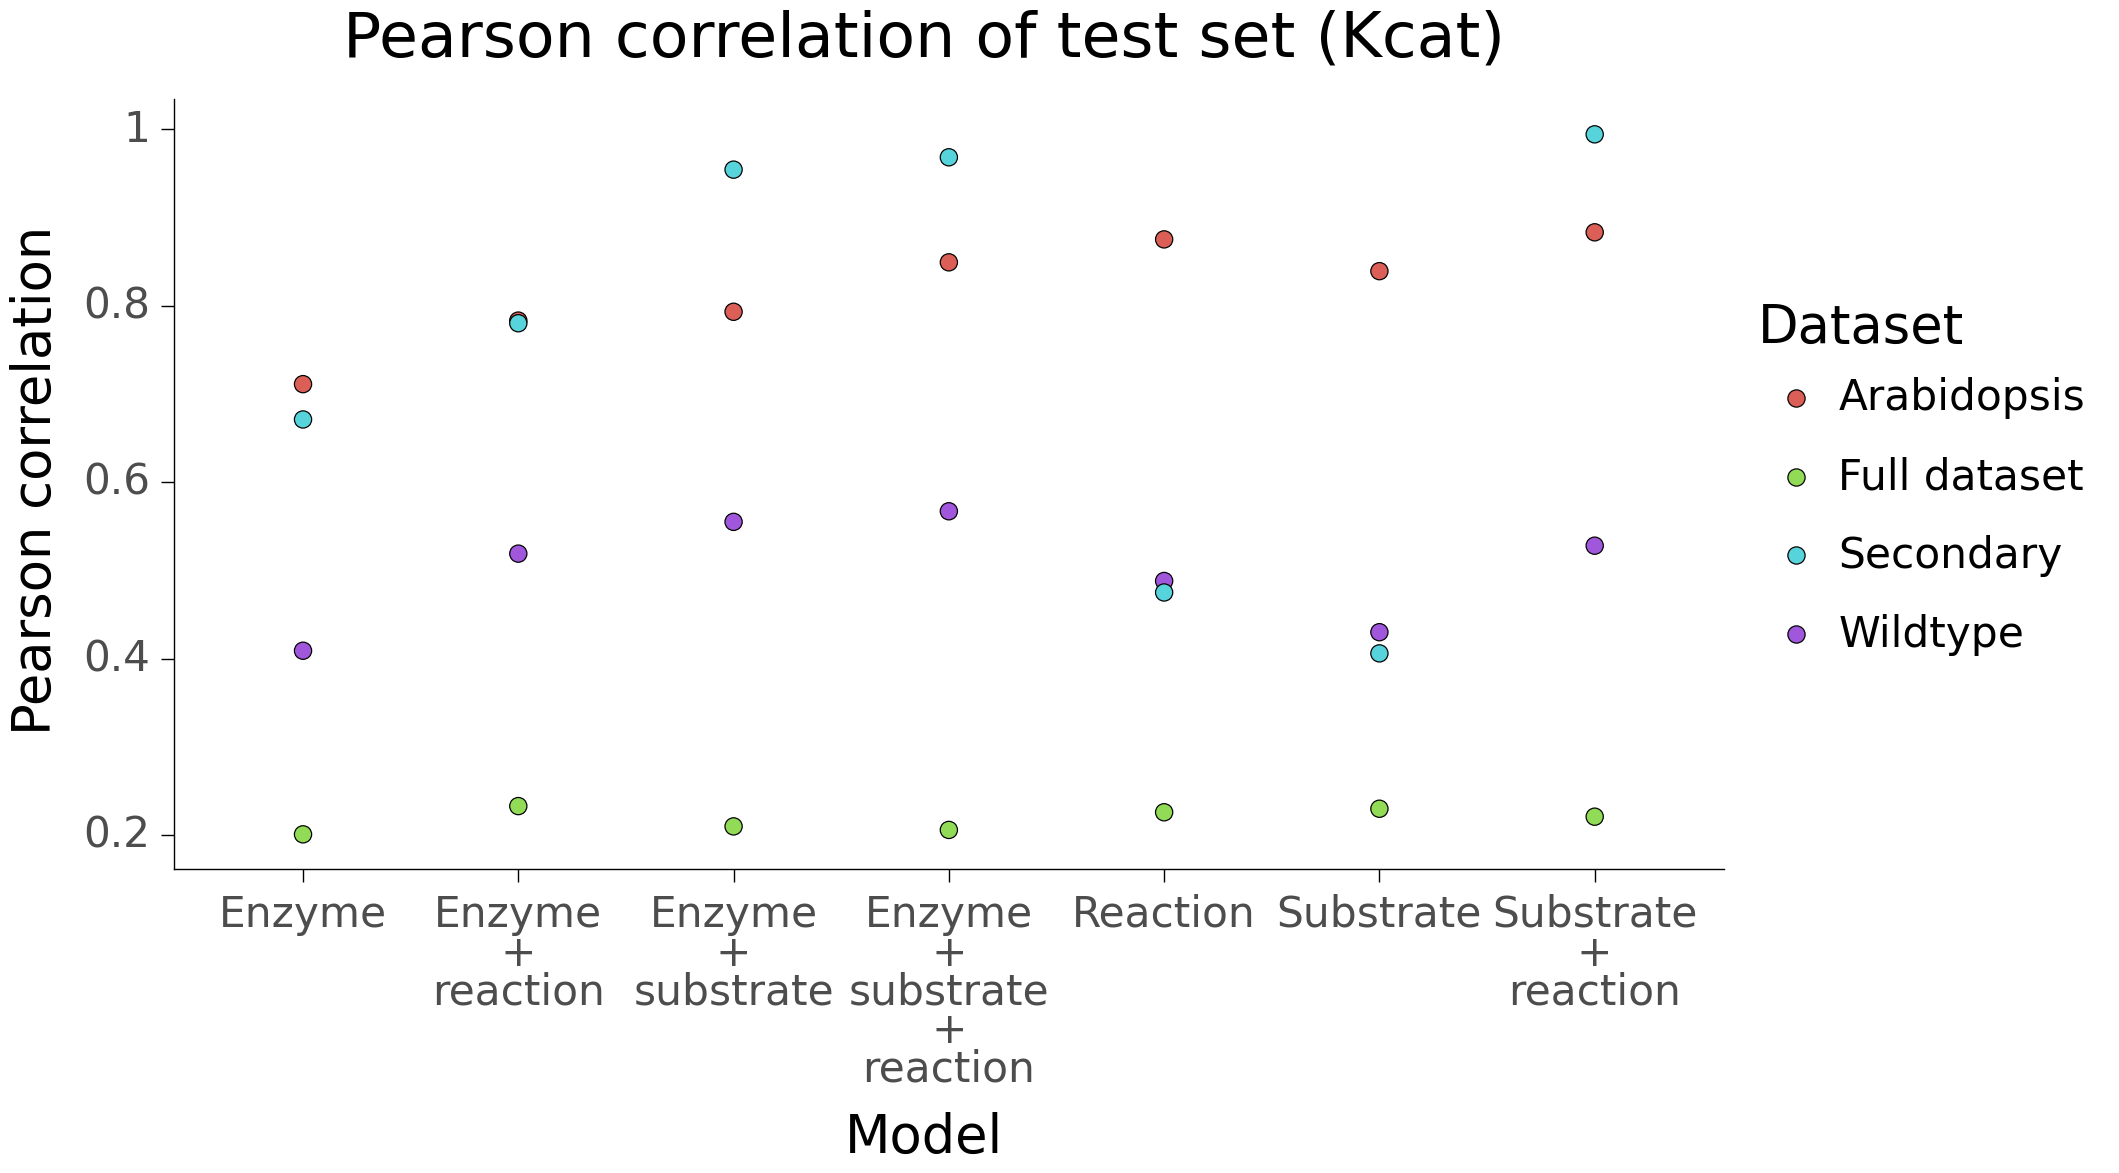

<ggplot: (-9223371855096725232)>

In [ ]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    labs,
    theme_classic,
    theme,
    scale_x_discrete
)

import textwrap

(
    ggplot(results_test, aes(x = "Model", y="Pearson correlation"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="Pearson correlation of test set (Kcat)", x="Model", y="Pearson correlation", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)



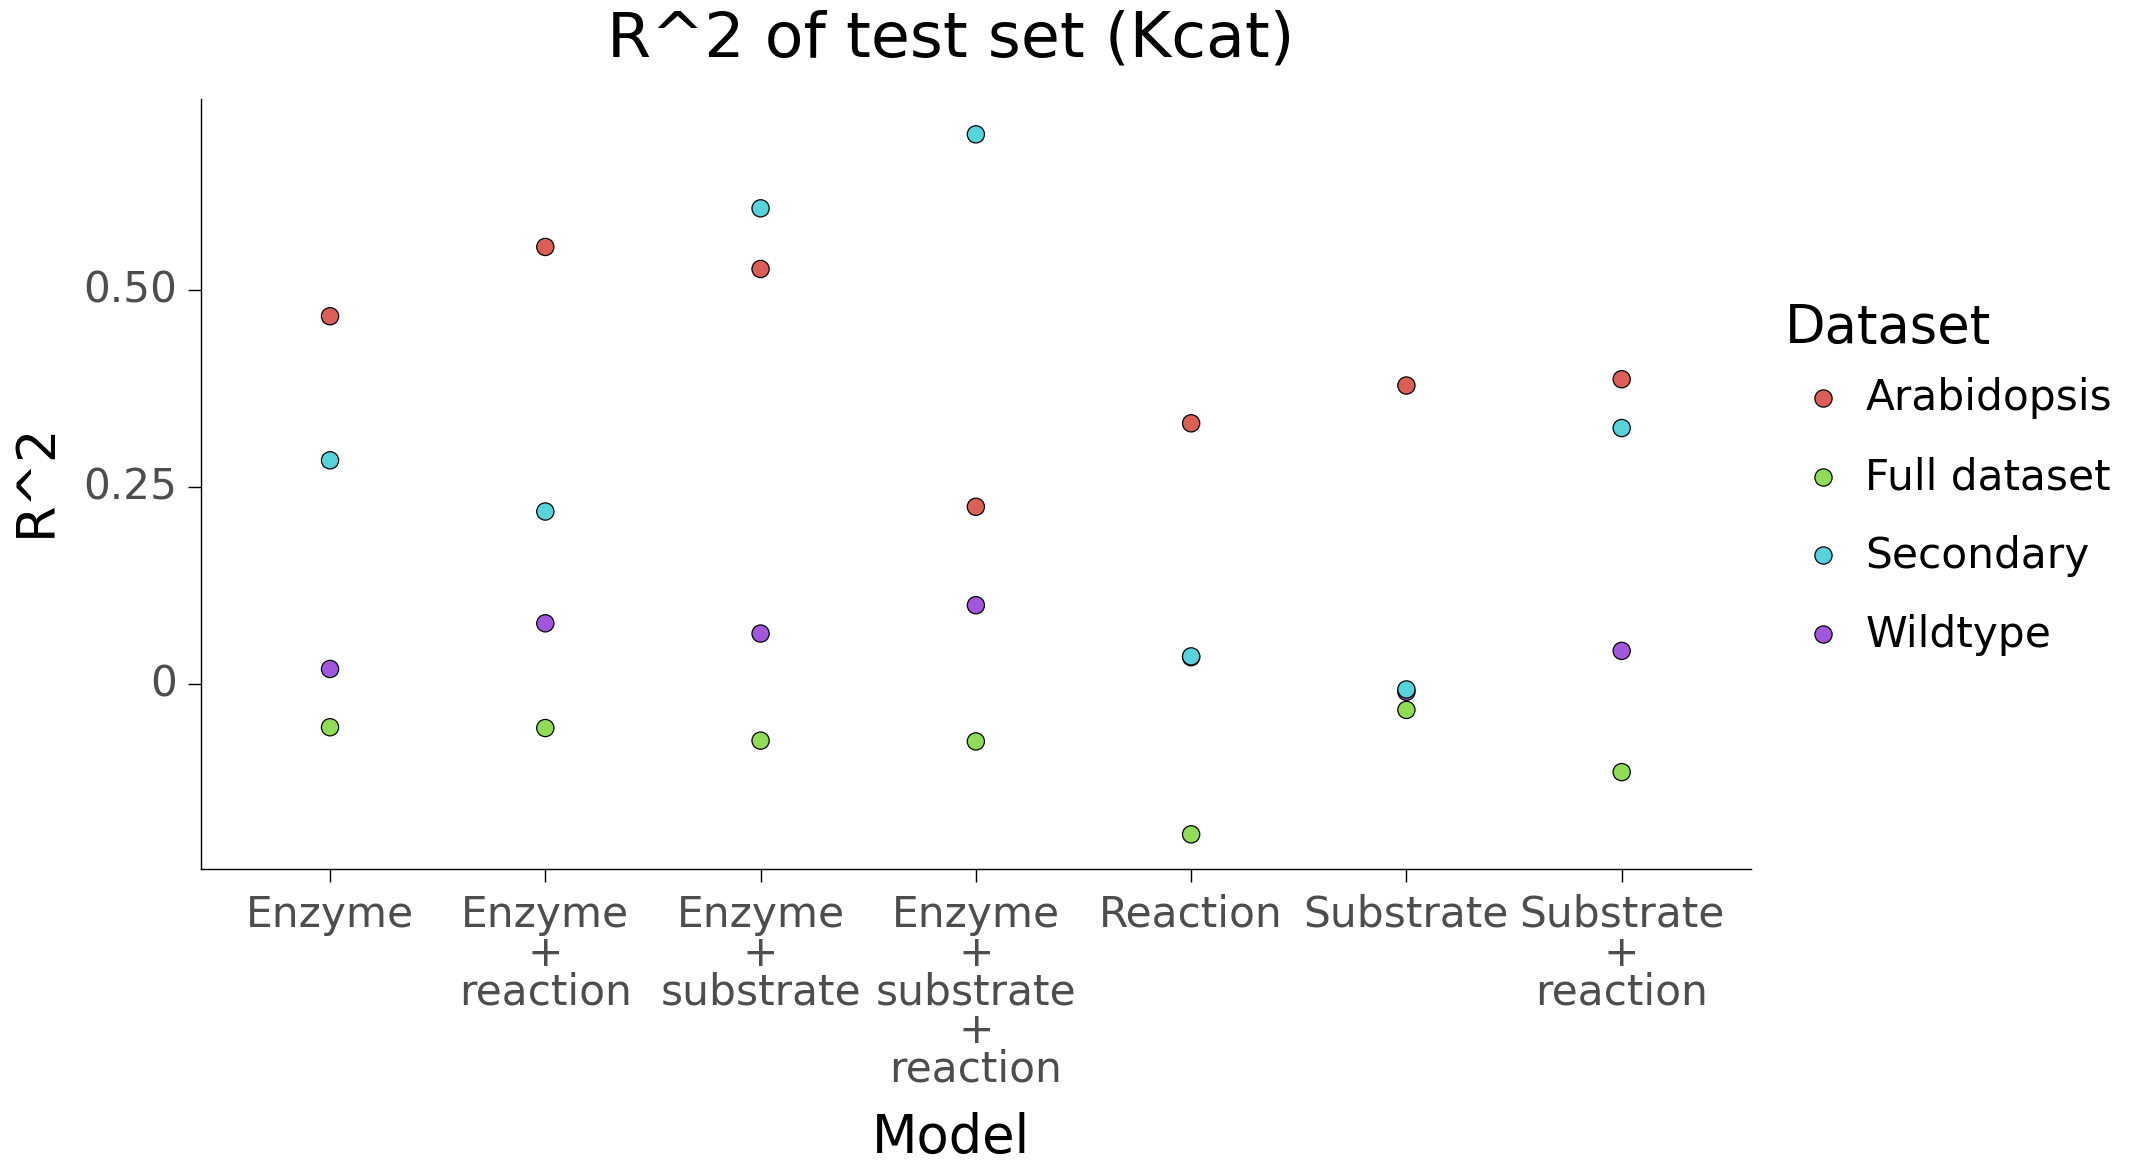

<ggplot: (-9223371855091904456)>

In [ ]:
(
    ggplot(results_test, aes(x = "Model", y="R^2"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="R^2 of test set (Kcat)", x="Model", y="R^2", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)

In [ ]:
results_val = pd.read_csv('../../data/Results_val.csv')

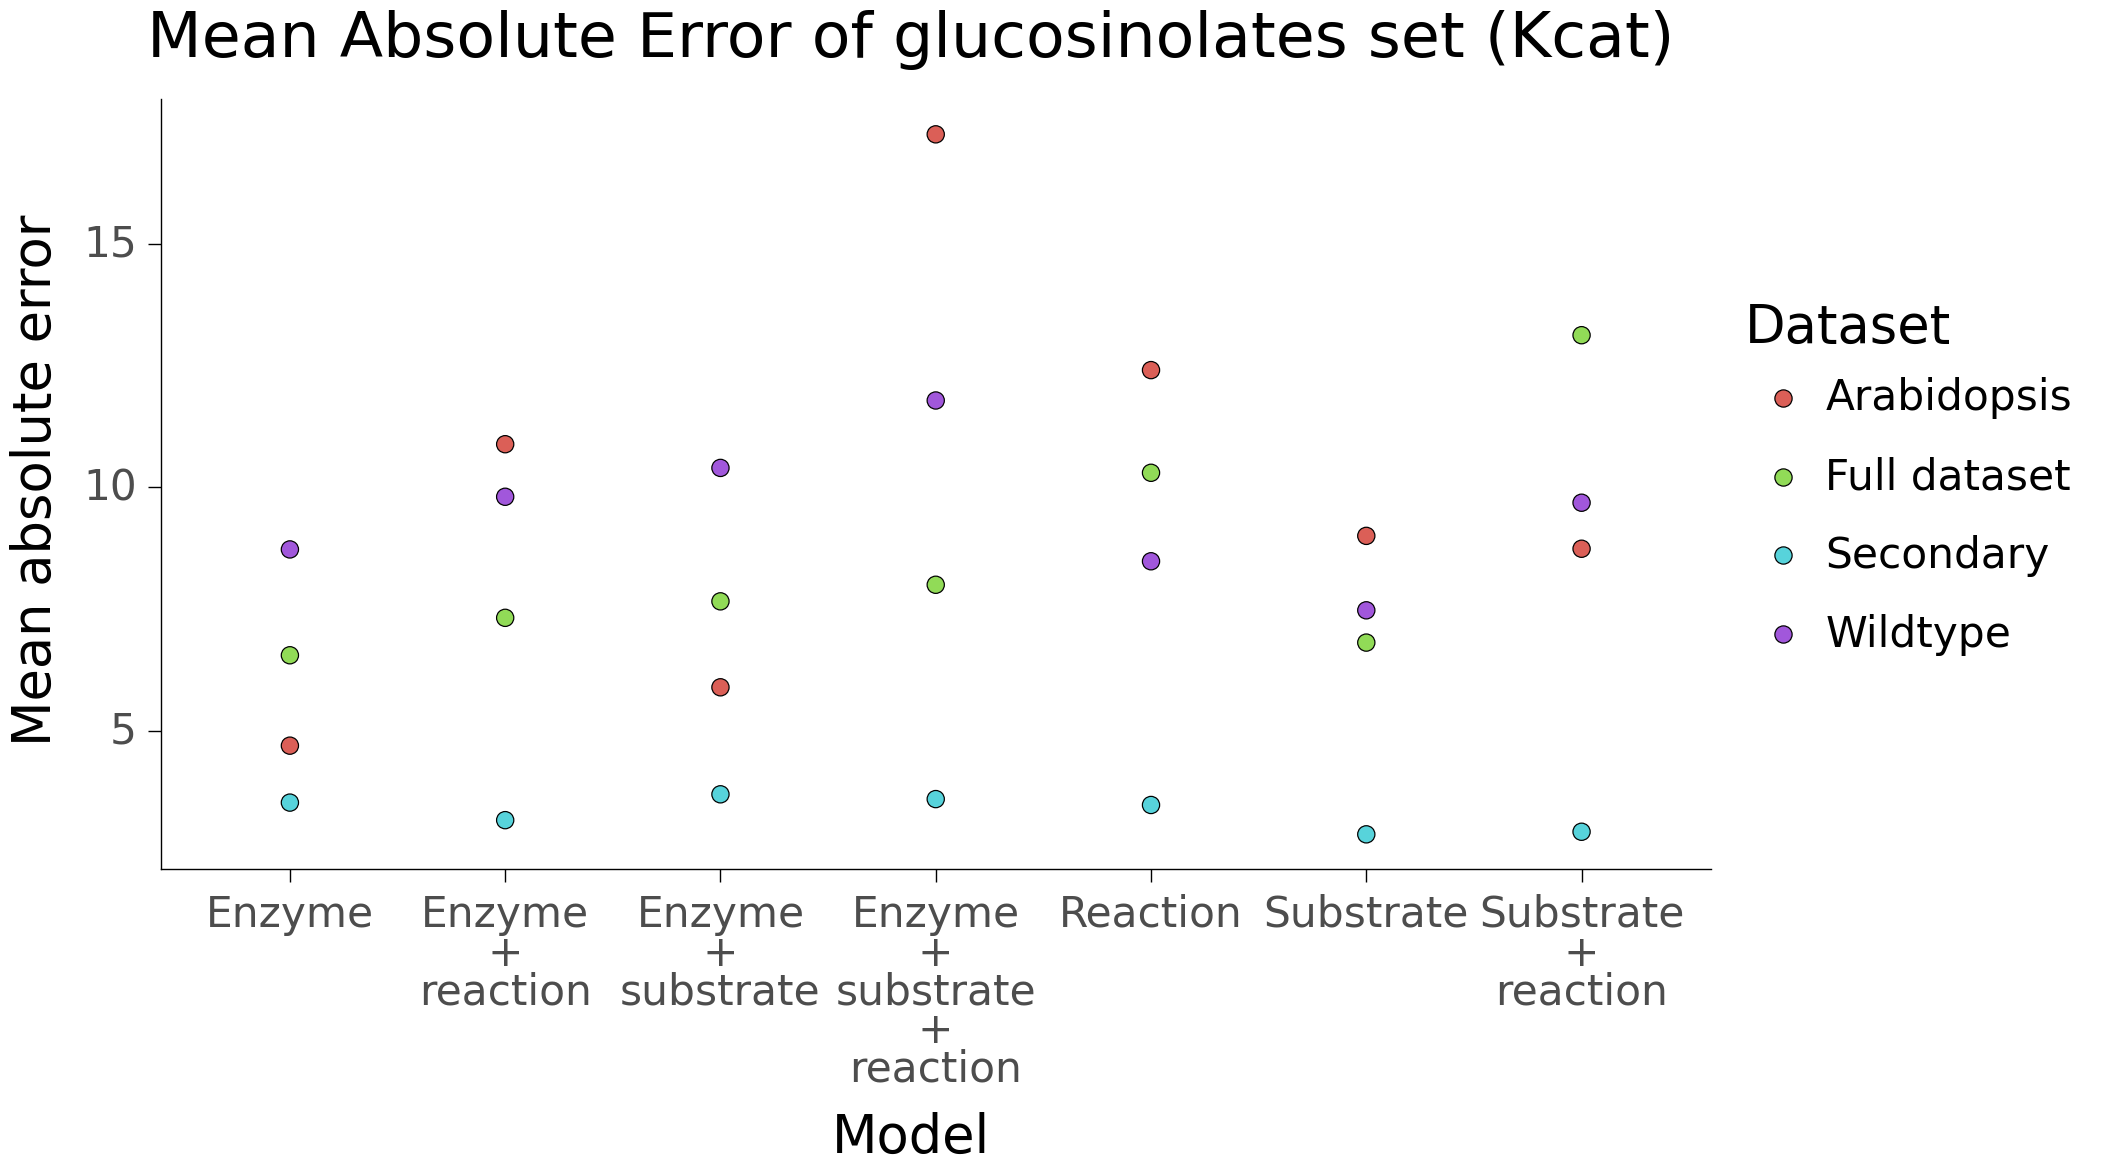

<ggplot: (-9223371855095576612)>

In [ ]:
from plotnine import (
    ggplot,
    aes,
    geom_point,
    labs,
    theme_classic,
    theme,
    scale_x_discrete
)

import textwrap

(
    ggplot(results_val, aes(x = "Model", y="MAE"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="Mean Absolute Error of glucosinolates set (Kcat)", x="Model", y="Mean absolute error", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)



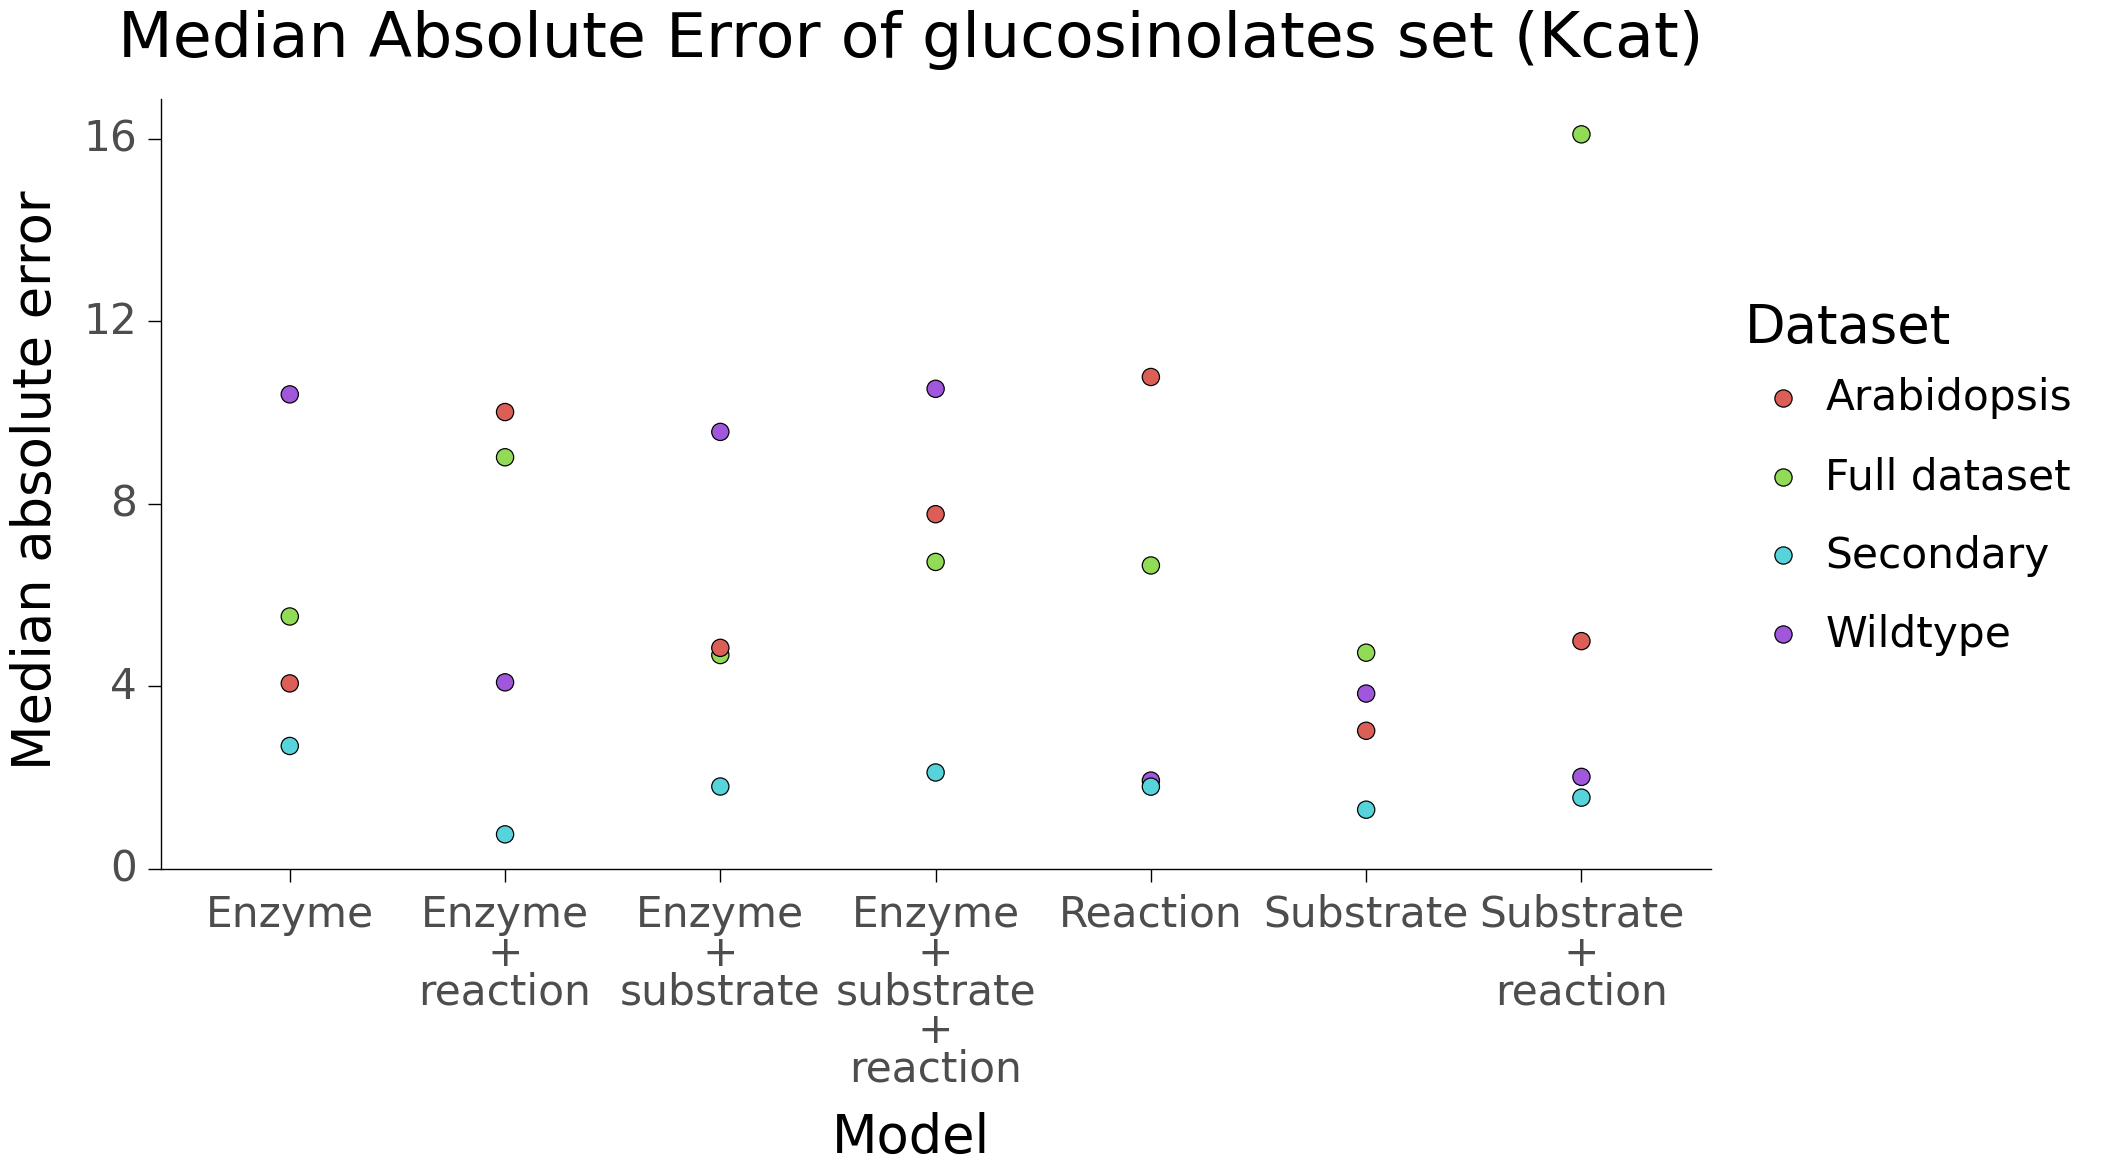

<ggplot: (-9223371855091901204)>

In [ ]:
(
    ggplot(results_val, aes(x = "Model", y="MedAE"))
    + geom_point(aes(fill="Dataset"), size=6.5) 
    + scale_x_discrete(labels= ["Enzyme","Enzyme\n+\nreaction", "Enzyme\n+\nsubstrate", "Enzyme\n+\nsubstrate\n+\nreaction", "Reaction", "Substrate", "Substrate\n+\nreaction"])
    + labs(title="Median Absolute Error of glucosinolates set (Kcat)", x="Model", y="Median absolute error", fill="Dataset")
    + theme_classic(base_size=38)
    + theme(figure_size=(20, 10))
)